In [1]:
# Sitting up the environnement
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

Loading data

In [2]:
site_traffic_df = pd.read_csv("./recipe_site_traffic_2212.csv")
site_traffic_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


Data info

In [3]:
site_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


First things first, we can see that there is some data missing in calories, carbohydrate, sugar, protein and high_traffic columns. Second, category, servings high_traffic columns are pandas objects (categorical).
According to the product manager 'servings' must be numerical so let's start with converting it to numeric.

1. ## Data Preprocessing

#### Dealing with "servings" column

Converting servings to integers as required

In [4]:
site_traffic_df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

As we can see, there are some elements in the servings column that must be processed in the form of {integer+"as a snack"}.

In [5]:
site_traffic_df['servings'] = pd.to_numeric(site_traffic_df['servings'].str.split().str[0], errors='coerce')

Let's check if the column's data type has changed to numerical (integer)

In [6]:
site_traffic_df['servings'].dtype

dtype('int64')

Okay, moving on..

#### Dealing with "category" column

What categories do we have ?

In [7]:
category_list = list(site_traffic_df['category'].unique())
print(category_list, "\nN°categories =",len(category_list))

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat', 'Dessert'] 
N°categories = 11


Comparing with the list provided by the manager

In [8]:
managers_category_list = ['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast','One Dish Meal']
for cat in category_list:
    if cat not in managers_category_list:
        print(cat)

Chicken Breast


We can classify 'Chicken Breast' with the 'Chicken' category

In [9]:
site_traffic_df['category'] = site_traffic_df['category'].str.replace('Chicken Breast','Chicken')

Let's check now if we have the same categories as the manager's

In [10]:
print(site_traffic_df['category'].unique())
print(site_traffic_df['category'].unique().shape)

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']
(10,)


Great ! Moving on..

#### Dealing with "high_trafic" column

We only have 'High' traffic or null values in this column

In [11]:
site_traffic_df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [12]:
missing_high_traffic = site_traffic_df['high_traffic'].isnull().sum()
missing_high_traffic

373

In [13]:
ratio = missing_high_traffic/len(site_traffic_df['high_traffic'])
ratio*100

39.38753959873284

About 39% of the data is missing in the 'high_traffic' column. At this stage we cannot define null values as 'High' or 'Not High' simply because the recipes aren't shown on the site yet (or shown but no high traffic was observed and no data was delivered, let's just call it unknown). Having a set of recipes we will be predicting the ones that lead to high traffic.

In [14]:
site_traffic_df['high_traffic'] = site_traffic_df['high_traffic'].fillna('unknown')
site_traffic_df['high_traffic'].sample(10)

886       High
861       High
601    unknown
442       High
517       High
110    unknown
750    unknown
848       High
789       High
877    unknown
Name: high_traffic, dtype: object

#### Dealing with missing values

For the rows that have null values for 'calories', 'carbohydrate', 'sugar' and 'protein' at once, it is better to drop them simply because without them we cannot define a recipe (and setting them to 0 or mean of data is not relevant).

In [15]:
columns_of_interest = ['calories', 'carbohydrate', 'sugar', 'protein']
missing_values_df = site_traffic_df[site_traffic_df[columns_of_interest].isnull().all(axis=1)]
missing_values_df.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
530,531,NaN,NaN,NaN,NaN,Vegetable,1,High
538,539,NaN,NaN,NaN,NaN,Vegetable,4,High
943,944,NaN,NaN,NaN,NaN,Potato,2,High
354,355,NaN,NaN,NaN,NaN,Pork,4,High
82,83,NaN,NaN,NaN,NaN,Meat,4,High
326,327,NaN,NaN,NaN,NaN,Potato,4,High
938,939,NaN,NaN,NaN,NaN,Pork,4,High
351,352,NaN,NaN,NaN,NaN,Potato,4,High
683,684,NaN,NaN,NaN,NaN,Potato,1,High
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,High


We count 52 observations where 'calories', 'carbohydrate', 'sugar' and 'protein' columns all have null values at once. 52+895=947 which is the length of our dataset. Now we can drop the corresponding rows and we're sure that we're dropping only rows where we have null values for the four items.

In [16]:
site_traffic_df_cleaned = site_traffic_df.copy()
site_traffic_df_cleaned = site_traffic_df_cleaned.dropna(subset=columns_of_interest, how='all')
site_traffic_df_cleaned.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
636,637,2029.33,25.08,0.61,54.00,One Dish Meal,1,High
858,859,388.44,12.89,4.62,13.93,Pork,4,High
185,186,1266.75,154.18,0.59,0.46,Lunch/Snacks,4,High
529,530,448.59,181.98,36.47,12.03,One Dish Meal,6,High
29,30,164.76,33.58,17.87,220.14,One Dish Meal,2,High
239,240,593.56,243.20,0.60,2.56,Chicken,2,unknown
758,759,253.63,12.99,5.75,9.50,Potato,1,unknown
757,758,853.22,24.80,0.90,14.10,Lunch/Snacks,4,unknown
457,458,796.74,44.85,2.36,3.44,Potato,4,High
840,841,84.91,28.31,9.90,41.53,Chicken,6,High


Now that we have a clean dataset, let's explore it !

In [17]:
# Quick check
site_traffic_df_cleaned['high_traffic'].value_counts('unknown')*100

high_traffic
High       59.776536
unknown    40.223464
Name: proportion, dtype: float64

40% of the data is still to predict (unknown), we must be careful about our class imbalance.

2. ## Data Exploration

#### Dataset Description

In [18]:
site_traffic_df_cleaned.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


Interquartile Range (IQR)

In [19]:
iqr = site_traffic_df_cleaned['calories'].quantile(0.75) - site_traffic_df_cleaned['calories'].quantile(0.25)

# just checking if we have the same quantiles in the description table
print("First Quantile:", site_traffic_df_cleaned['calories'].quantile(0.25), "Third Quantile", site_traffic_df_cleaned['calories'].quantile(0.75))

# Interquantile Range
print("IQR =", iqr)

First Quantile: 110.43 Third Quantile 597.65
IQR = 487.21999999999997


While the columns for 'recipe' and 'servings' may offer limited insight, the remaining columns in the dataset provide more substantial information for analysis.
I can read the results but the table is more insightful.
Let me analyze the 'calories' for you :
- Skewness: The median (288.55) being less than the mean (435.94) suggests a positively skewed distribution. This skewness is further indicated by the fact that the IQR (487.22) is larger than the mean.
- Variability: The large difference between the IQR and the median indicates substantial variability in the middle 50% of the dataset.
- Outliers: The large difference between the mean and the median, as well as the large IQR, suggest the possible presence of outliers on the higher end of the distribution. These outliers are likely influencing the mean and contributing to the positively skewed distribution.
- Central Tendency: The fact that the median is substantially lower than the mean indicates that the distribution is heavily influenced by the higher values, pulling the mean upwards. In this case, the median may be a more representative measure of central tendency, especially in the presence of outliers.

#### Some visualizations

To validate the previous interpretations let's visualize data.

<Axes: ylabel='calories'>

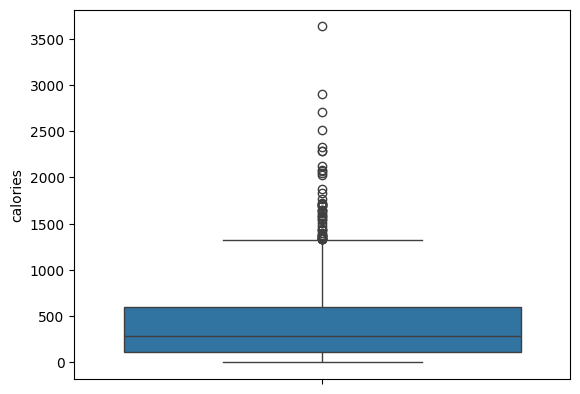

In [20]:
sns.boxplot(data=site_traffic_df_cleaned['calories'])

Most of 'calories' data is concentrated in the range [100,600]. Here we can observe the presence of outliers that can affect our analysis but we have a great solution for this which is data normalization, so let's not worry about this.

[]

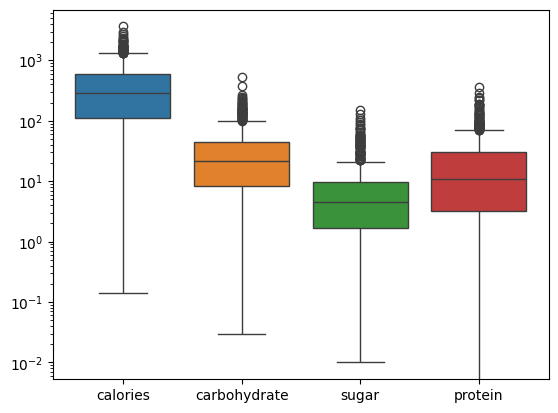

In [31]:
# Boxplot for all recipe elements
recipes_cols = site_traffic_df_cleaned.columns[1:-3]
sns.boxplot(data=site_traffic_df_cleaned[recipes_cols])
plt.semilogy()

We can see the presence of outliers also for the other items (recipe and servings are not representative).

Now let's verify the distribution skewness of 'calories'

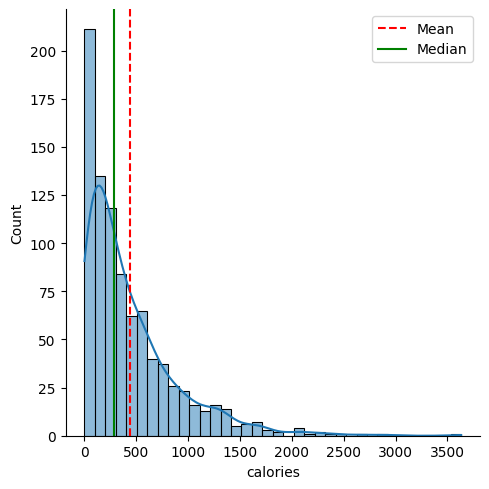

In [27]:
# plotting calories distribution
sns.displot(site_traffic_df_cleaned['calories'], kde='true')

# vertical line at the mean
plt.axvline(site_traffic_df_cleaned['calories'].mean(), color='r', linestyle='--', label='Mean')

# vertical line at the median
plt.axvline(site_traffic_df_cleaned['calories'].median(), color='g', linestyle='-', label='Median')

# legend
plt.legend()

# display
plt.show()

In [28]:
# skewness calculation
skewness = site_traffic_df_cleaned['calories'].skew()
print("Skewness:", skewness)

Skewness: 2.036150959685193


The value of skewness is greater than 1, this distribution is highly skewed to the right.

#### Relationship between two variables

Out of curiosity, let's plot the correlation matrix of recipes.

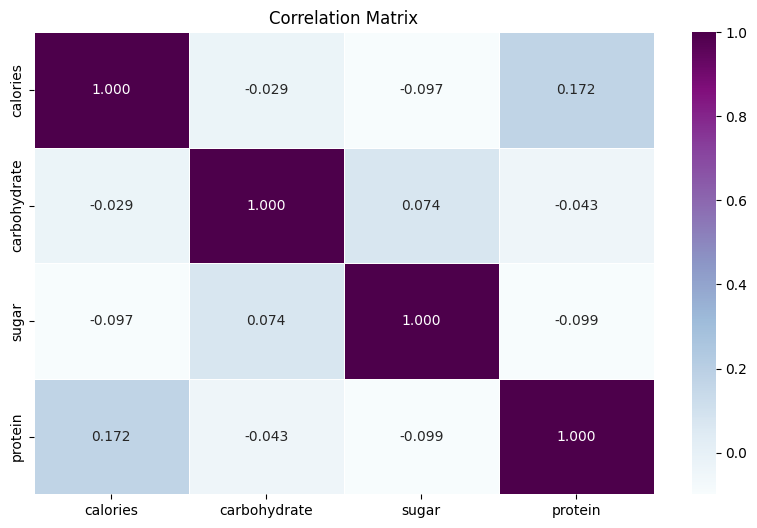

In [33]:
correlation_matrix = site_traffic_df_cleaned[recipes_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".3f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In this matrix we can see if we have positive or negative correlation between two variables (calories vs protein, sugar vs carbohydrate, sugar vs calories, etc.), it is important to note that this doesn't prove any relationship between these variables because one variable (calories for example) can depend on all the other variables and not only one.

Now a pairplot to see the distribution of each item and the distribution of each correlation between the varaibles.

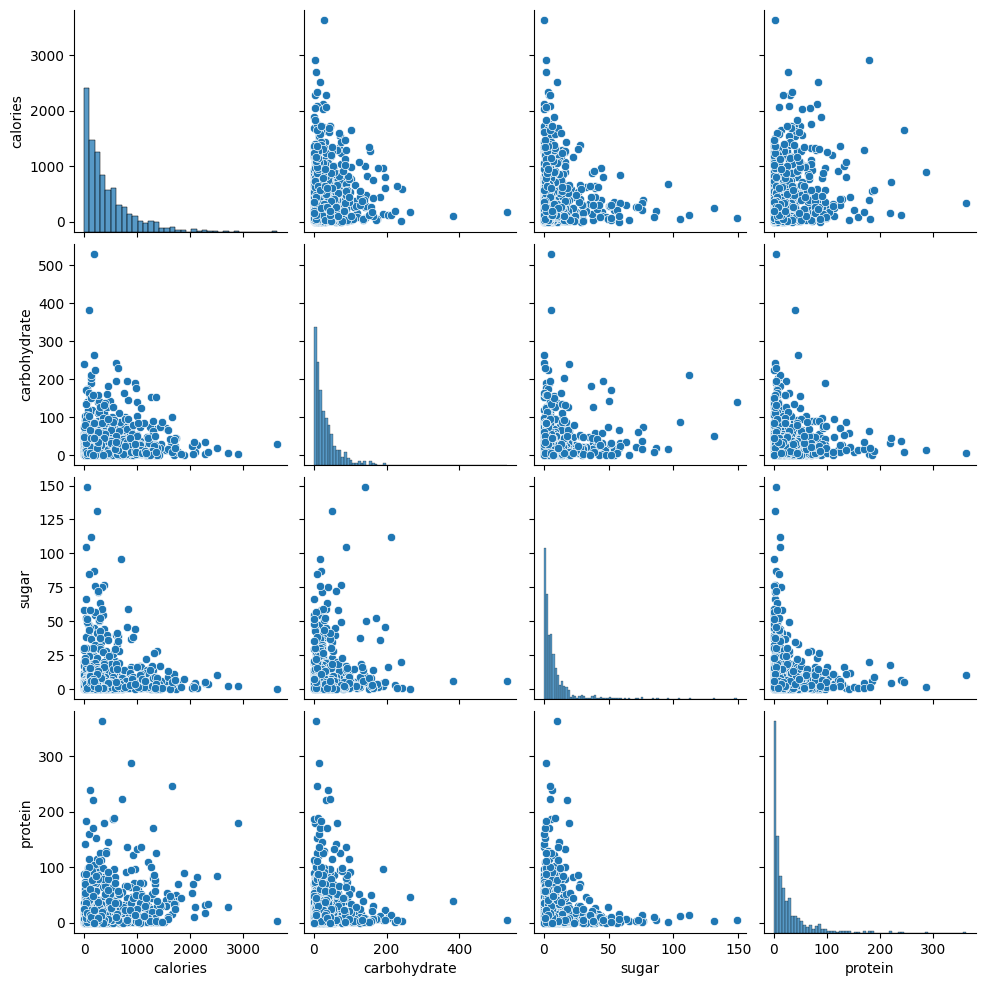

In [34]:
sns.pairplot(site_traffic_df_cleaned[recipes_cols])

#### Relationship between calories and category

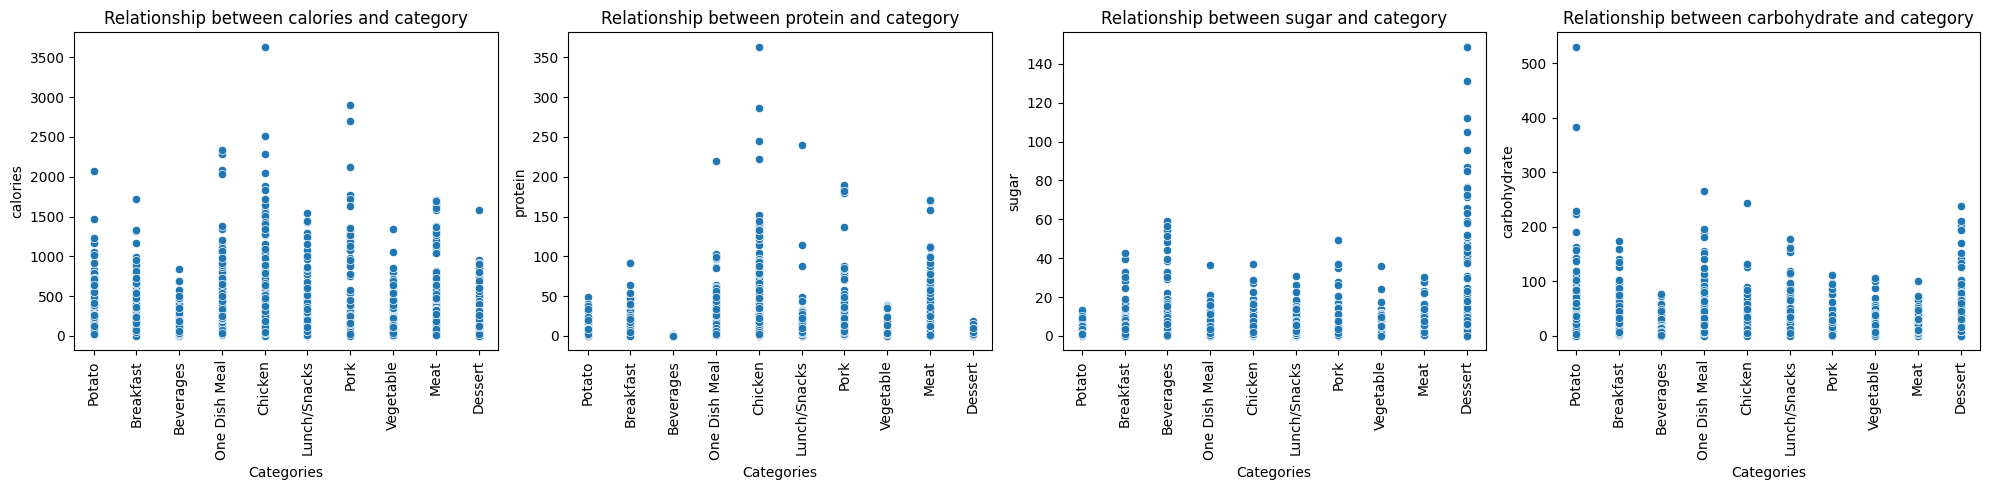

In [35]:
columns_to_plot = site_traffic_df_cleaned[['calories', 'protein', 'sugar', 'carbohydrate']]

# figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# scatter plot in a separate subplot
for i, col in enumerate(columns_to_plot):
    sns.scatterplot(x=site_traffic_df_cleaned['category'], y=site_traffic_df_cleaned[col], ax=axes[i])
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel(str(col))
    axes[i].set_title(f'Relationship between {col} and category')
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels if needed

# layout adjusting and plot display
plt.tight_layout()
plt.show()

Here we can see that : 
- Chicken and Pork contain the highest calories
- Chicken, One Dish Meal and Lunch/Snack have the highest protein
- Dessert has the highest sugar
- Potato has the highest carbohydrate


# 3. Model Developement

Selecting a suitable model for this problem is relatively simple because the goal is now defined : predict which recipes lead to a High traffic. Traffic as a variable in this universe can take a binary state : 'High', 'Not High'. As a result, we can use logistic regression for to classify traffic. Other models like Decision Trees, Random Forests, Support Vector Machines (SVM), and Gradient Boosting Machines (GBM) also can be used but I personnaly prefer to apply cross-validation to select the most suitable model for any problem.

### 3.1. Model Selection : Corss-Validation

Before implementing any predictive model we must convert categorical data to numerical. I will be using a Label Encoder for this purpose.

In [36]:
label_encoder = LabelEncoder()

In [37]:
site_traffic_df_encoded = site_traffic_df_cleaned.copy()
site_traffic_df_encoded['category_encoded'] = label_encoder.fit_transform(site_traffic_df_encoded['category'])
site_traffic_df_encoded['traffic_encoded'] = label_encoder.fit_transform(site_traffic_df_encoded['high_traffic'])
site_traffic_df_encoded = site_traffic_df_encoded.drop(columns=['high_traffic', 'category'])
site_traffic_df_encoded

,recipe,calories,carbohydrate,sugar,protein,servings,category_encoded,traffic_encoded
1,2,35.48,38.56,0.66,0.92,4,8,0
2,3,914.28,42.68,3.09,2.88,1,1,1
3,4,97.03,30.56,38.63,0.02,4,0,0
4,5,27.05,1.85,0.80,0.53,4,0,1
5,6,691.15,3.46,1.65,53.93,2,6,0
...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,4,2,0
942,943,1161.00,5.31,22.39,44.22,2,4,1
944,945,951.74,29.42,3.57,13.87,2,7,0
945,946,266.61,35.77,0.97,8.07,6,8,0


Here, High traffic is encoded as 0 and unknown traffic as 1.

In [38]:
# Features
X = site_traffic_df_encoded.drop(columns='traffic_encoded')
X.sample(10)

,recipe,calories,carbohydrate,sugar,protein,servings,category_encoded
479,480,525.28,62.46,1.27,10.85,1,4
773,774,597.75,34.77,4.70,38.26,1,2
199,200,52.32,2.84,2.96,88.21,4,5
157,158,766.80,13.60,8.27,17.85,6,4
810,811,336.13,38.56,75.48,14.64,1,3
374,375,298.69,1.18,11.47,0.03,6,0
508,509,135.85,23.89,12.38,14.89,1,8
845,846,399.59,56.13,5.77,4.81,2,3
829,830,912.77,79.94,1.85,44.36,1,6
676,677,261.88,0.58,12.87,1.76,1,0


In [40]:
# Features Normilization (crutial with the presence of outliers)
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)
X_scaled

array([[-1.73013106, -0.88446917,  0.07946194, ..., -0.63905558,
         0.31233238,  1.36519865],
       [-1.72646283,  1.0564814 ,  0.17325931, ..., -0.58513449,
        -1.41676545, -1.06462225],
       [-1.72279459, -0.74852753, -0.10266887, ..., -0.66381526,
         0.31233238, -1.41173952],
       ...,
       [ 1.72901215,  1.13921696, -0.12862251, ..., -0.28279124,
        -0.84039951,  1.01808138],
       [ 1.73268038, -0.3739868 ,  0.01594382, ..., -0.44235365,
         1.46506428,  1.36519865],
       [ 1.73634861, -0.5552055 ,  0.23085819, ..., -0.66354015,
         0.31233238, -1.41173952]])

In [42]:
# Target
y = site_traffic_df_encoded['traffic_encoded']
y.sample(10)

42     1
417    0
558    1
935    0
537    1
819    0
237    1
641    1
912    1
580    1
Name: traffic_encoded, dtype: int64

### Model Selection

In [43]:
# Models that i will test
logistic_regression_model = LogisticRegression(random_state=0)
random_forest_model = RandomForestClassifier(random_state=0)
svc_model = SVC(random_state=0)
gradient_boosting_model = GradientBoostingClassifier(random_state=0)
decision_tree_model = DecisionTreeClassifier(random_state=0)

models = [
    ("Logistic Regression", logistic_regression_model),
    ("Decision Tree", decision_tree_model),
    ("Random Forest", random_forest_model),
    ("SVC", svc_model),
    ("Gradient Boosting", gradient_boosting_model)
]

In [44]:
def model_comparaison(list_models, X_train, y_train, X_test, y_test):
    
    models_train_accuracies = []
    models_test_accuracies = []
    
    for item in list_models:
        model = item[1]
        model.fit(X_train, y_train) # Model training
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Training set performance
        accuracy_train = accuracy_score(y_pred_train, y_train)
        f1score_train = f1_score(y_pred_train, y_train)
        precision_train = precision_score(y_pred_train, y_train)
        recall_train = recall_score(y_pred_train, y_train)
        roc_auc_train = roc_auc_score(y_pred_train, y_train)
        
        models_train_accuracies.append((item[1], accuracy_train))
        
        # Test set performance
        accuracy_test = accuracy_score(y_pred_test, y_test)
        f1score_test = f1_score(y_pred_test, y_test)
        precision_test = precision_score(y_pred_test, y_test)
        recall_test = recall_score(y_pred_test, y_test)
        roc_auc_test = roc_auc_score(y_pred_test, y_test)
        
        models_test_accuracies.append((item[1], accuracy_test))
        
        print("\033[94mModel:\033[0m", model)
        print("----------------- Training Set Performance ------------------")
        print("- Accuracy=", accuracy_train)
        print("- F1-Score=", f1score_train)
        print("- Precision=", precision_train)
        print("- Recall=", recall_train)
        print("- ROC AUC=", roc_auc_train)
        
        print("----------------- Test Set Performance ----------------------")
        print("- Accuracy=", accuracy_test)
        print("- F1-Score=", f1score_test)
        print("- Precision=", precision_test)
        print("- Recall=", recall_test)
        print("- ROC AUC=", roc_auc_test, "\n")

In [46]:
# Which split to use ?

for i in range(5,51,5):
    print(f"================= \033[91mAt test size= {i/100}\033[0m  ==================")
    Xi_train, Xi_test, yi_train, yi_test = train_test_split(X_scaled, y, test_size=(i/100), random_state=0)
    model_comparaison(list_models=models, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

================= At test size= 0.05  ==================
Model: LogisticRegression(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 0.7644736842105263
- F1-Score= 0.7108239095315024
- Precision= 0.7213114754098361
- Recall= 0.7006369426751592
- ROC AUC= 0.7550269915169517
----------------- Test Set Performance ----------------------
- Accuracy= 0.7777777777777778
- F1-Score= 0.7222222222222221
- Precision= 0.7090909090909091
- Recall= 0.7358490566037735
- ROC AUC= 0.7703635526921307 

Model: DecisionTreeClassifier(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 1.0
- F1-Score= 1.0
- Precision= 1.0
- Recall= 1.0
- ROC AUC= 1.0
----------------- Test Set Performance ----------------------
- Accuracy= 0.6518518518518519
- F1-Score= 0.5688073394495413
- Precision= 0.5636363636363636
- Recall= 0.5740740740740741
- ROC AUC= 0.6388888888888888 

Model: RandomForestClassifier(random_state=0)
----------------- Tr

In [48]:
# Split at test size = 0.15 seems to be the best choice
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=0)
print(X_train.shape, y_train.shape)

(760, 7) (760,)


In [49]:
# Using our best split
model_comparaison(list_models=models, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Model: LogisticRegression(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 0.7644736842105263
- F1-Score= 0.7108239095315024
- Precision= 0.7213114754098361
- Recall= 0.7006369426751592
- ROC AUC= 0.7550269915169517
----------------- Test Set Performance ----------------------
- Accuracy= 0.7777777777777778
- F1-Score= 0.7222222222222221
- Precision= 0.7090909090909091
- Recall= 0.7358490566037735
- ROC AUC= 0.7703635526921307 

Model: DecisionTreeClassifier(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 1.0
- F1-Score= 1.0
- Precision= 1.0
- Recall= 1.0
- ROC AUC= 1.0
----------------- Test Set Performance ----------------------
- Accuracy= 0.6518518518518519
- F1-Score= 0.5688073394495413
- Precision= 0.5636363636363636
- Recall= 0.5740740740740741
- ROC AUC= 0.6388888888888888 

Model: RandomForestClassifier(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 1.0

Although it's not performing better than SVC or Gradient Boosting models on the training set, Logistic Regression model provides a better performance on the test set which makes it the most suitable for our study.
Decision tree, Random forest and Gradient Boosting models seem to be overfitting so they will be excluded from our analysis.

### Hyperparameters tunning

In [50]:
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Penalty type
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'newton-cholesky', 'saga']  # Solver algorithm
}
svc_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'gamma': [0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Kernel type
}

tuning_models = [
    ("Logistic Regression", LogisticRegression(), lr_params),
    ("SVM", SVC(), svc_params)
]

#### GridSearchCV

In [51]:
# Grid Search
for name, model, params in tuning_models:
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # best hyperparameters found
    print(f"Best Hyperparameters for {name}", grid_search.best_params_)

    # best model
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test set
    best_model_accuracy = best_model.score(X_test, y_test)
    
    print(f"Best Accuracy for {name} model", best_model_accuracy, "\n")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

Best Hyperparameters for Logistic Regression {'C': 1, 'penalty': 'l2', 'solver': 'newton-cholesky'}
Best Accuracy for Logistic Regression model 0.7777777777777778 

Best Hyperparameters for SVM {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
Best Accuracy for SVM model 0.762962962962963 



#### Using RandomizedSearchCV

In [52]:
model_param = {}
for name, model, params in tuning_models:
    randomized_search = RandomizedSearchCV(estimator=model,
                                          param_distributions=params,
                                          n_iter=100,
                                          cv=5,
                                          verbose=1,
                                          n_jobs=-1)
    randomized_search.fit(X_train, y_train)
    model_param[name] = randomized_search.best_params_
    best_score = randomized_search.score(X_test,y_test)
    print("Accuracy:", best_score)

for model_name in model_param:
    print(f"Best parameters for {model_name} : {model_param[model_name]}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File

Accuracy: 0.7777777777777778
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Accuracy: 0.762962962962963
Best parameters for Logistic Regression : {'solver': 'newton-cholesky', 'penalty': 'l2', 'C': 1}
Best parameters for SVM : {'kernel': 'linear', 'gamma': 0.1, 'C': 10}


In [53]:
lr_model_tuned = LogisticRegression(penalty='l2', C=1, solver='newton-cholesky')
svc_model_tunned = SVC(kernel='linear', gamma='0.1', C=10)

It's strange to get lower accuracy for tuned model - to be continued..

In [54]:
def count_unknown(y_data):
    ylist = list(y_data)
    s = 0
    for elem in ylist:
        if elem==1:
            s+=1
    
    print("Number of unknown (1)", s)
    print("y dimension=", len(y_data))
    ratio = s/len(y_data)
    print("Ratio:", ratio)

count_unknown(y_train)

Number of unknown (1) 305
y dimension= 760
Ratio: 0.40131578947368424


In [56]:
lr_model_tuned.fit(X_train, y_train)

y_pred = lr_model_tuned.predict(X_test)
accuracy_lr = accuracy_score(y_pred, y_test)
balanced_accuracy = balanced_accuracy_score(y_pred, y_test)
print("Accyracy : ", accuracy_lr)
print("Balanced Accuracy : ", balanced_accuracy)

Accyracy :  0.7777777777777778
Balanced Accuracy :  0.7703635526921306


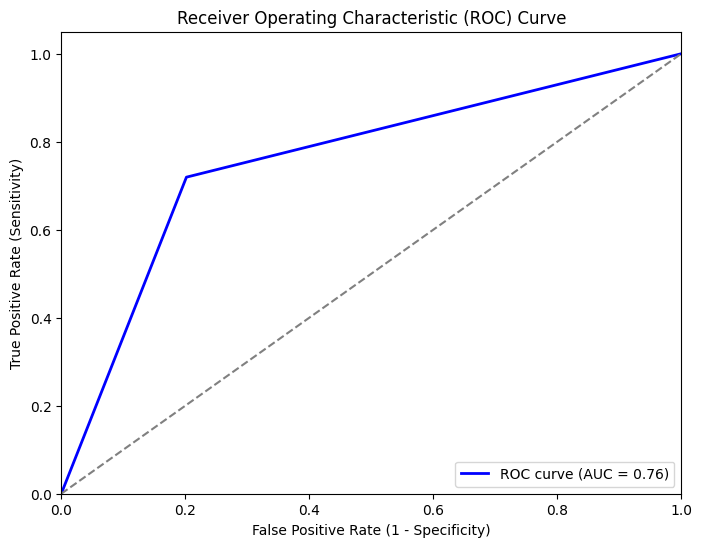

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix

y_pred_testt = lr_model_tuned.predict(X_scaled)

# Compute ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y, y_pred_testt)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [58]:
confusion_matrix(y_test, y_pred)

array([[66, 14],
       [16, 39]])

As our data seem to be imbalanced it was already predicted to get relatively poor performance. Let's sample data and try to solve our class imbalance problem.
It is important to note that accuracy is not appropriate when the data is imbalanced. Because the model can achieve higher accuracy by just predicting accurately the majority class while performing poorly on the minority class which in most valuable for us.

### Oversampling

In [60]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE
from imblearn.combine import SMOTEENN

# oversampling techniques
oversamplers = {
    "ADASYN": ADASYN(random_state=0),
    "Borderline-SMOTE": BorderlineSMOTE(random_state=0),
    "SMOTE": SMOTE(random_state=0),
    "SMOTE-ENN": SMOTEENN(random_state=0)
}

for name, oversampler in oversamplers.items():
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    
    # model training using resampled data
    model = logistic_regression_model  # Replace YourModel with your actual model
    model.fit(X_train_resampled, y_train_resampled)
    
    # model evaluation on the test set
    accuracy = model.score(X_test, y_test)
    print(f"{name}: Accuracy = {accuracy}")

ADASYN: Accuracy = 0.762962962962963
Borderline-SMOTE: Accuracy = 0.7555555555555555
SMOTE: Accuracy = 0.7703703703703704
SMOTE-ENN: Accuracy = 0.7037037037037037


Oversampling doesn't seem to be working in our favour because our goal is to predict 80% of high traffic correctly and here the accuracy of our model is decreasing.

In [61]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

In [62]:
scores = []
y_train_list = np.array(y_train)

for train_idx, val_idx in rskf.split(X_train, y_train):
    Xcross_train, ycross_train = X_train[train_idx], y_train_list[train_idx]
    X_val, y_val = X_train[val_idx], y_train_list[val_idx]
    
    logistic_regression_model.fit(Xcross_train, ycross_train)
    ycross_pred = lr_model_tuned.predict(X_val)
    
    scores.append(accuracy_score(ycross_pred, y_val))

print("Scores:", scores)
print("Mean =", np.mean(scores))

Scores: [0.7763157894736842, 0.8026315789473685, 0.756578947368421, 0.756578947368421, 0.7302631578947368, 0.7171052631578947, 0.7368421052631579, 0.7763157894736842, 0.8157894736842105, 0.7763157894736842, 0.756578947368421, 0.7828947368421053, 0.75, 0.7828947368421053, 0.75]
Mean = 0.7644736842105263


### A bit of deep learning

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(0)

# model architecture
tf_model = Sequential([
    Dense(64, activation='relu', input_shape=(7,)),
    Dense(80, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
tf_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training the model
tf_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = tf_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.5395 - val_loss: 0.5921 - val_accuracy: 0.7039
Epoch 2/10
24/24 [==============================] - 0s 1ms/step - loss: 0.5636 - accuracy: 0.7197 - val_loss: 0.5357 - val_accuracy: 0.7500
Epoch 3/10
24/24 [==============================] - 0s 1ms/step - loss: 0.5194 - accuracy: 0.7368 - val_loss: 0.5152 - val_accuracy: 0.7368
Epoch 4/10
24/24 [==============================] - 0s 1ms/step - loss: 0.5012 - accuracy: 0.7342 - val_loss: 0.5071 - val_accuracy: 0.7500
Epoch 5/10
24/24 [==============================] - 0s 1ms/step - loss: 0.4947 - accuracy: 0.7447 - val_loss: 0.5020 - val_accuracy: 0.7434
Epoch 6/10
24/24 [==============================] - 0s 2ms/step - loss: 0.4896 - accuracy: 0.7526 - val_loss: 0.4971 - val_accuracy: 0.7434
Epoch 7/10
24/24 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.7474 - val_loss: 0.4917 - val_accuracy: 0.7500
Epoch 8/10
24/24 [==

In [65]:
results = tf_model.predict(X_scaled)

28/28 [==============================] - 0s 307us/step


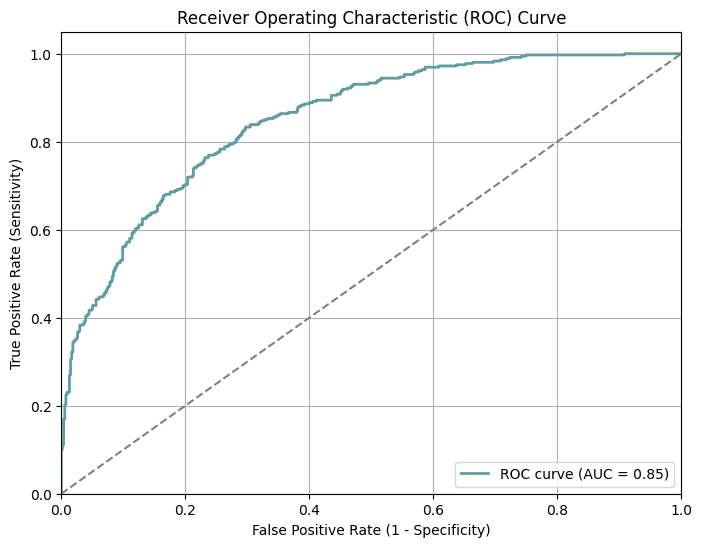

In [66]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix

# Compute ROC curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y, results)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='cadetblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

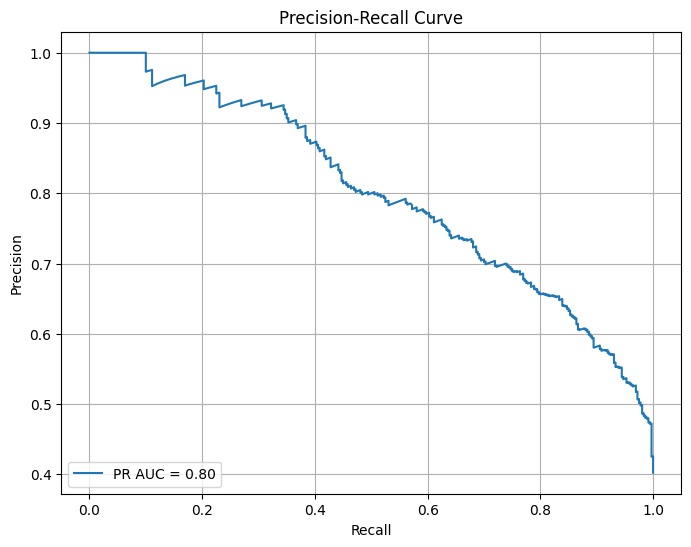

In [67]:
precision, recall, thresholds = precision_recall_curve(y, results)

# Compute Area Under the Curve (AUC)
auc_score = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [68]:
# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.78
binary_predictions = [1 if prediction > threshold else 0 for prediction in results.flatten()]

# Print the binary predictions
count_unknown(binary_predictions)

Number of unknown (1) 102
y dimension= 895
Ratio: 0.11396648044692738


In [69]:
site_traffic_df_encoded['DL_results'] = binary_predictions
site_traffic_df_encoded

,recipe,calories,carbohydrate,sugar,protein,servings,category_encoded,traffic_encoded,DL_results
1,2,35.48,38.56,0.66,0.92,4,8,0,0
2,3,914.28,42.68,3.09,2.88,1,1,1,0
3,4,97.03,30.56,38.63,0.02,4,0,0,0
4,5,27.05,1.85,0.80,0.53,4,0,1,1
5,6,691.15,3.46,1.65,53.93,2,6,0,0
...,...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,4,2,0,0
942,943,1161.00,5.31,22.39,44.22,2,4,1,0
944,945,951.74,29.42,3.57,13.87,2,7,0,0
945,946,266.61,35.77,0.97,8.07,6,8,0,0


In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.losses import BinaryCrossentropy  # Loss function

tf.random.set_seed(0)

# Data preprocessing (replace with your data loading and preparation)
# X_train: Training features, y_train: Training labels (0 or 1)
# X_test: Testing features, y_test: Testing labels (0 or 1)

# Define the MLP model
keras_model = Sequential([
  Dense(64, activation='relu', input_shape=(7,)),
  Dense(80, activation='relu'),
  Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
keras_model.compile(optimizer=Adam(learning_rate=(0.001)),  # Adjust learning rate as needed
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])
# Train the model
keras_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model (on unseen test data)
loss, accuracy = keras_model.evaluate(X_test, y_test)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)


Epoch 1/10
24/24 [==============================] - 0s 4ms/step - loss: 0.6356 - accuracy: 0.6434 - val_loss: 0.5687 - val_accuracy: 0.6776
Epoch 2/10
24/24 [==============================] - 0s 1ms/step - loss: 0.5463 - accuracy: 0.7368 - val_loss: 0.5167 - val_accuracy: 0.7434
Epoch 3/10
24/24 [==============================] - 0s 990us/step - loss: 0.5065 - accuracy: 0.7368 - val_loss: 0.4984 - val_accuracy: 0.7632
Epoch 4/10
24/24 [==============================] - 0s 979us/step - loss: 0.4911 - accuracy: 0.7513 - val_loss: 0.4944 - val_accuracy: 0.7697
Epoch 5/10
24/24 [==============================] - 0s 990us/step - loss: 0.4870 - accuracy: 0.7539 - val_loss: 0.4924 - val_accuracy: 0.7632
Epoch 6/10
24/24 [==============================] - 0s 984us/step - loss: 0.4839 - accuracy: 0.7487 - val_loss: 0.4903 - val_accuracy: 0.7632
Epoch 7/10
24/24 [==============================] - 0s 1ms/step - loss: 0.4797 - accuracy: 0.7566 - val_loss: 0.4853 - val_accuracy: 0.7829
Epoch 8/10
2

In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.losses import BinaryCrossentropy  # Loss function

tf.random.set_seed(0)

# Data preprocessing (replace with your data loading and preparation)
# X_train: Training features (sequences), y_train: Training labels (0 or 1)
# X_test: Testing features (sequences), y_test: Testing labels (0 or 1)

# Define the RNN model
rnn_model = Sequential([
  LSTM(80, return_sequences=True, input_shape=(7,1)),  # Adjust for sequence length
  LSTM(80),  # No return_sequences for final layer
  Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
rnn_model.compile(optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model (on unseen test data)
loss, accuracy = rnn_model.evaluate(X_test, y_test)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

Epoch 1/10
24/24 [==============================] - 3s 24ms/step - loss: 0.6732 - accuracy: 0.6237 - val_loss: 0.6473 - val_accuracy: 0.6776
Epoch 2/10
24/24 [==============================] - 0s 6ms/step - loss: 0.6460 - accuracy: 0.6303 - val_loss: 0.6238 - val_accuracy: 0.6908
Epoch 3/10
24/24 [==============================] - 0s 6ms/step - loss: 0.6133 - accuracy: 0.6566 - val_loss: 0.5819 - val_accuracy: 0.7039
Epoch 4/10
24/24 [==============================] - 0s 6ms/step - loss: 0.5445 - accuracy: 0.7263 - val_loss: 0.5144 - val_accuracy: 0.7434
Epoch 5/10
24/24 [==============================] - 0s 6ms/step - loss: 0.5124 - accuracy: 0.7342 - val_loss: 0.5260 - val_accuracy: 0.7566
Epoch 6/10
24/24 [==============================] - 0s 6ms/step - loss: 0.5040 - accuracy: 0.7513 - val_loss: 0.5084 - val_accuracy: 0.7303
Epoch 7/10
24/24 [==============================] - 0s 6ms/step - loss: 0.5010 - accuracy: 0.7539 - val_loss: 0.5062 - val_accuracy: 0.7434
Epoch 8/10
24/24 [=

In [72]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, valid_scores_mean, 'o-', label='Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

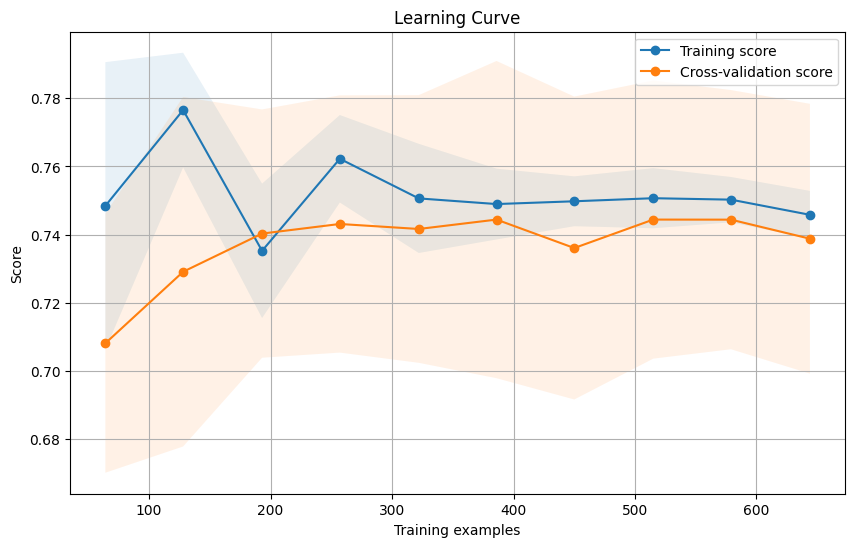

In [59]:
# Learning curve for model with 80% accuracy, randomstate=883
plot_learning_curve(logistic_regression_model_req, X_train_req, y_train_req)

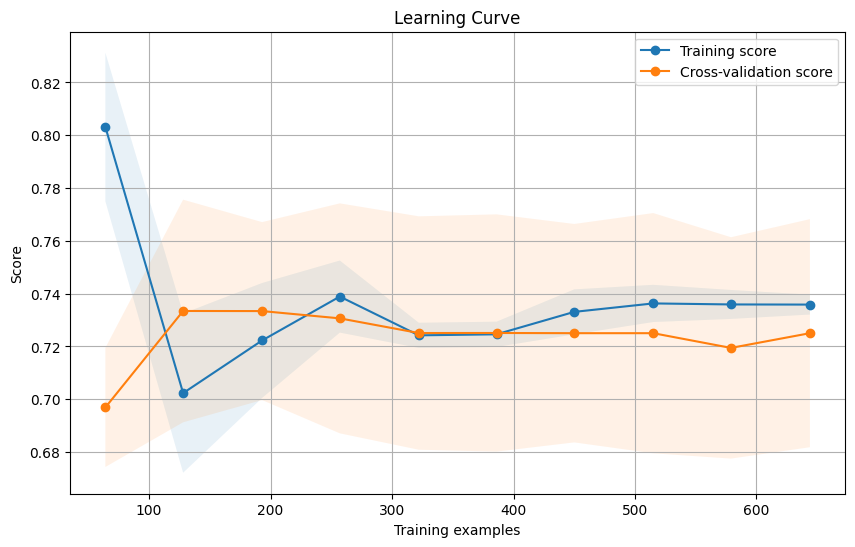

In [60]:
# Learning curve for model with 85% accuracy
plot_learning_curve(logistic_regression_model_best, X_train_best, y_train_best)

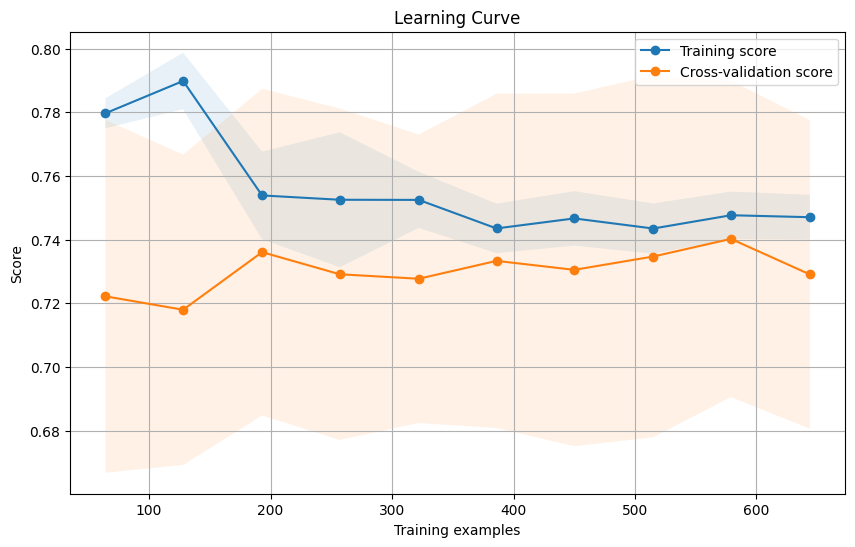

In [85]:
# Learning curve for model with 80% accuracy, randomstate=10
plot_learning_curve(logistic_regression_model_10, X_train_10, y_train_10)

And now let's see what we got for our initial dataset

In [54]:
# Using manager's requirements
y_pred1 = logistic_regression_model.predict(X_scaled)
y_pred1.shape

In [55]:
# For best accuracy
y_pred2 = logistic_regression_model_best.predict(X_scaled)
y_pred2.shape

In [86]:
y_pred3 = logistic_regression_model_10.predict(X_scaled)
y_pred3.shape

(895,)

In [115]:
y_pred4 = random_forest_model.predict(X_scaled)
y_pred4.shape

(895,)

In [58]:
predictions_df = site_traffic_df_cleaned.copy()
predictions_df['required_predictions'] = label_encoder.inverse_transform(y_pred1)
predictions_df['best_predictions'] = label_encoder.inverse_transform(y_pred2)
#predictions_df['final_predictions'] = label_encoder.inverse_transform(y_pred3)
predictions_df['RF_predictions'] = label_encoder.inverse_transform(y_pred4)
predictions_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,category_encoded,traffic_encoded,required_predictions,best_predictions,RF_predictions
1,2,35.48,38.56,0.66,0.92,Potato,4,High,8,0,High,High,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,unknown,1,1,unknown,unknown,unknown
3,4,97.03,30.56,38.63,0.02,Beverages,4,High,0,0,unknown,unknown,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,unknown,0,1,unknown,unknown,unknown
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High,6,0,High,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,Chicken,4,High,2,0,unknown,unknown,unknown
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,unknown,4,1,High,High,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High,7,0,High,High,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High,8,0,High,High,High


In [59]:
unknown_traffic_df = predictions_df[predictions_df['high_traffic']=='unknown']
unknown_traffic_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,category_encoded,traffic_encoded,required_predictions,best_predictions,RF_predictions
2,3,914.28,42.68,3.09,2.88,Breakfast,1,unknown,1,1,unknown,unknown,unknown
4,5,27.05,1.85,0.80,0.53,Beverages,4,unknown,0,1,unknown,unknown,unknown
6,7,183.94,47.95,9.75,46.71,Chicken,4,unknown,2,1,unknown,unknown,unknown
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,unknown,4,1,High,High,unknown
9,10,248.28,48.54,3.99,113.85,Chicken,2,unknown,2,1,unknown,High,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,933,1017.32,85.12,1.71,1.85,Potato,1,unknown,8,1,High,High,unknown
939,940,2283.29,34.34,5.12,17.57,Chicken,6,unknown,2,1,unknown,unknown,unknown
940,941,1337.50,49.91,0.76,57.90,Chicken,4,unknown,2,1,unknown,unknown,High
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,unknown,4,1,High,High,High


In [73]:
high_traffic_df1 = unknown_traffic_df[unknown_traffic_df['required_predictions']=='High']
high_traffic_df2 = unknown_traffic_df[unknown_traffic_df['best_predictions']=='High']
#high_traffic_df3 = unknown_traffic_df[unknown_traffic_df['final_predictions']=='High']
high_traffic_df4 = unknown_traffic_df[unknown_traffic_df['RF_predictions']=='High']

NameError: name 'unknown_traffic_df' is not defined

It seems that at best accuracy we're able to eliminate 2 'wrong' predictions, not bad but we may think of tunning the model to produce more 'High' traffic because 94 predictions among 360 might not be very satisfying fot the manager :). Note that if at this stage the model was at the best possible performance we can say that the rest of the unknown states are simply the ones that correspond to 'Not High' traffic.

In [65]:
# Prediction Ratio
R1 = len(high_traffic_df1)/len(site_traffic_df[site_traffic_df['high_traffic']=='unknown'])*100
R1

27.61394101876676

In [66]:
# Prediction Ratio
R2 = len(high_traffic_df2)/len(site_traffic_df[site_traffic_df['high_traffic']=='unknown'])*100
R2

26.273458445040216

In [105]:
R3 = len(high_traffic_df3)/len(site_traffic_df[site_traffic_df['high_traffic']=='unknown'])*100
R3

26.273458445040216

In [69]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix_req = confusion_matrix(y_test, y_pred_req)
print("Confusion Matrix:")
print(conf_matrix_req)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_req))

Confusion Matrix:
[[85 21]
 [21 52]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       106
           1       0.71      0.71      0.71        73

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



In [70]:
conf_matrix_best = confusion_matrix(y_test_best, y_pred_best)
print("Confusion Matrix:")
print(conf_matrix_best)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_best, y_pred_best))

Confusion Matrix:
[[86 12]
 [14 67]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        98
           1       0.85      0.83      0.84        81

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



- Accuracy: The second model (85%) outperforms the first model (80%) in terms of overall accuracy, indicating that it makes correct predictions for a higher proportion of instances.
- Precision: Both models have the same precision (86%), indicating that they have a similar ability to correctly identify positive instances (e.g., instances predicted as "high traffic") among all instances predicted as positive.
- Recall: The second model (88%) has a higher recall than the first model (82%), indicating that it captures a higher proportion of actual positive instances among all positive instances in the dataset.
- F1-score: The F1-score, which is the harmonic mean of precision and recall, is slightly higher for the second model (87%) compared to the first model (84%). This suggests that the second model achieves a better balance between precision and recall.
- ROC-AUC: The second model has a higher ROC-AUC score (0.89) than the first model (0.87), indicating better performance in terms of the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity).
- Confusion Matrix: The confusion matrices provide detailed information about the distribution of correct and incorrect predictions for each class. In both confusion matrices, the diagonal elements represent the number of correct predictions (true positives and true negatives), while the off-diagonal elements represent the number of incorrect predictions (false positives and false negatives).

### 3.2. Model Fine Tuning

BUT the most accurate model doesn't provide better results, this might be due to imbalanced calss weights.

In [133]:
from sklearn.utils.class_weight import compute_class_weight

# Computing class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_best), y=y_train_best)

class_weight = dict(zip(np.unique(y_train_best), class_weights))

# Train a logistic regression model with class weights
logreg_model_balanced = LogisticRegression(class_weight=class_weight)
logreg_model_balanced.fit(X_train_best, y_train_best)

# Make predictions on the test set
y_pred_best_balanced = logreg_model_balanced.predict(X_scaled)
predictions_df['balanced_predictions'] = label_encoder.inverse_transform(y_pred_best_balanced)
unknown_traffic_df_balanced = predictions_df[predictions_df['high_traffic']=='unknown']

In [139]:
high_traffic_df_balanced = unknown_traffic_df_balanced[unknown_traffic_df_balanced['best_predictions']=='High']
high_traffic_df_balanced

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,category_encoded,traffic_encoded,required_predictions,best_predictions,balanced_predictions
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,unknown,4,1,High,High,High
35,36,796.89,29.10,9.63,2.28,Lunch/Snacks,2,unknown,4,1,High,High,High
42,43,576.89,4.79,20.92,4.29,One Dish Meal,2,unknown,6,1,High,High,High
50,51,293.36,19.16,9.40,1.32,Pork,2,unknown,7,1,High,High,High
61,62,187.87,55.51,9.99,86.09,One Dish Meal,4,unknown,6,1,High,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,895,576.07,21.89,2.96,71.16,Pork,4,unknown,7,1,High,High,High
897,898,576.38,15.98,0.54,36.23,Pork,2,unknown,7,1,High,High,High
906,907,194.37,12.17,1.58,3.67,Lunch/Snacks,4,unknown,4,1,High,High,High
932,933,1017.32,85.12,1.71,1.85,Potato,1,unknown,8,1,High,High,High


#### 3.2.1. Using Ensemble Methods for fine tunning

1. Bagging (Bootstrap Aggregating):

In [149]:
from sklearn.ensemble import BaggingClassifier

# Bagging with logistic_regression_model_req
bagging_req = BaggingClassifier(base_estimator=logistic_regression_model_req, n_estimators=10, random_state=42)
bagging_req.fit(X_train_req, y_train_req)
y_pred_bagging_req = bagging_req.predict(X_test_req)

# Bagging with logistic_regression_model_best
bagging_best = BaggingClassifier(base_estimator=logistic_regression_model_best, n_estimators=10, random_state=42)
bagging_best.fit(X_train_best, y_train_best)
y_pred_bagging_best = bagging_best.predict(X_test_best)


2. Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Boosting with logistic_regression_model_req
adaboost_req = AdaBoostClassifier(base_estimator=logistic_regression_model_req, n_estimators=50, random_state=42)
adaboost_req.fit(X_train_req, y_train_req)
y_pred_adaboost_req = adaboost_req.predict(X_test_req)

# Boosting with logistic_regression_model_best
adaboost_best = AdaBoostClassifier(base_estimator=logistic_regression_model_best, n_estimators=50, random_state=42)
adaboost_best.fit(X_train_best, y_train_best)
y_pred_adaboost_best = adaboost_best.predict(X_test_best)

3. Stacking

In [152]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define meta-estimator (logistic regression)
meta_estimator = LogisticRegression()

# Stacking with logistic_regression_model_req and logistic_regression_model_best
estimators = [('req', logistic_regression_model_req), ('best', logistic_regression_model_best)]
stacking = StackingClassifier(estimators=estimators, final_estimator=meta_estimator)

# Fit stacking classifier with corresponding subsets of training data
stacking.fit(X_train_req, y_train_req)  # Use X_train_req and y_train_req for logistic_regression_model_req
y_pred_stacking = stacking.predict(X_test_best)
stacking_accuracy = accuracy_score(y_pred_stacking, y_test)
stacking_accuracy

0.5195530726256983

Okay, it's just getting worse.

In [67]:
# logistic regression model fitting
logit_model = sm.Logit(y_train_req, sm.add_constant(X_train_req))
logit_result = logit_model.fit()

# summary of logistic regression results
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.501186
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        traffic_encoded   No. Observations:                  716
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            7
Date:                Thu, 22 Feb 2024   Pseudo R-squ.:                  0.2603
Time:                        09:58:44   Log-Likelihood:                -358.85
converged:                       True   LL-Null:                       -485.15
Covariance Type:            nonrobust   LLR p-value:                 7.751e-51
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6256      0.100     -6.237      0.000      -0.822      -0.429
x1             0.0201      0.

- The value of the loss function is 0.5 (relatively small), meaning that the model acheived a good fit for the data.
- About 25% of the variance of the dependent variable (high traffic) is explained by the independent variables (recipes).
- The LLR p-value is extremly low so the model is statistically significant.